In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

%cd ../..

!hostname

/mnt/localdata/datasets/vervet1818-3d
medpc177


In [2]:
import os

import re
import pandas as pd
import numpy as np

import pli
import pli.image as im

from tqdm import tqdm

In [3]:
pca_path = "data/aa/pca_80/resnet50_planes8_962-1083_sphere_small/Vervet1818aa_60mu_70ms_s0898_x00-20_y00-13_PCA.h5"

###

import h5py as h5

with h5.File(pca_path, 'r') as f:
    mask = f['Valid'][:]
    pca_values = f['PCA'][:]
    eigenvalues = f['PCA'].attrs['eigenvalues']
    total_variance_explained = f['PCA'].attrs['variance_explained']
    n_components = f['PCA'].attrs['n_components']

In [4]:
import matplotlib.pyplot as plt

# Global configuration for matplotlib

# plt.rcParams['figure.dpi'] = 450
plt.rcParams['font.size'] = 8
plt.rcParams['xtick.labelsize'] = 6
plt.rcParams['ytick.labelsize'] = 6
plt.rcParams['axes.titlesize'] = 8
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['font.family'] = 'sans-serif'

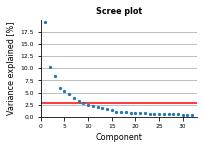

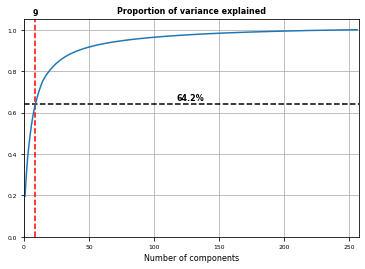

Total variance explained: 0.6420804412797525
Minimum variance explained per component: 0.028074945289893547


In [21]:
plot_comp_scree = int(256  / 8)

n_components = 9

###

# Plot explained variance

import matplotlib.pyplot as plt

cum_explained_variance = np.cumsum(eigenvalues)
eigensum = cum_explained_variance[-1]
cum_explained_variance /= eigensum

per_component_explained_variance = eigenvalues / eigensum

plt.figure(figsize=(2.8, 1.78))
plt.tight_layout()
plt.margins(x=0, y=0)
plt.grid(axis='y', zorder=0)

# Remove the top and right spines
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

plt.scatter(np.arange(1, plot_comp_scree + 1), 100 * per_component_explained_variance[:plot_comp_scree],  s=5, zorder=5)

plt.hlines(100 * per_component_explained_variance[n_components - 1], xmin=0, xmax=plot_comp_scree + 1, color='red')

# plt.scatter(n_components, 100 * per_component_explained_variance[n_components - 1], s=20, zorder=3, color='red')

# plt.vlines(n_components, scree.max(), 0, colors='black', linestyles='--')
plt.title("Scree plot", weight='bold')
plt.xlabel("Component")
plt.ylabel("Variance explained [%]")
plt.xlim(0, plot_comp_scree + 1)
plt.ylim(0, np.max(per_component_explained_variance[:plot_comp_scree]) * 100 * 1.02)
plt.savefig("doc/pca/scree.pdf")
plt.savefig("doc/pca/scree.svg")
plt.show()



plt.plot(np.arange(1, len(cum_explained_variance) + 1), cum_explained_variance)
plt.ylim(0, cum_explained_variance[-1] + 0.05)
plt.xlim(0, len(cum_explained_variance) + 1)
plt.hlines(cum_explained_variance[n_components - 1], 0, len(cum_explained_variance) + 1, colors='black', linestyles='--')
plt.vlines(n_components, 0, cum_explained_variance.max() + 0.1, colors='black', linestyles='--', color='red')

plt.text(n_components, cum_explained_variance.max() + 0.06, f'{n_components}', ha='center', va='bottom', weight='bold')
plt.text(len(eigenvalues) / 2, cum_explained_variance[n_components - 1] + 0.01, f'{cum_explained_variance[n_components - 1] * 100:.1f}%', ha='center', va='bottom', weight='bold')

plt.title("Proportion of variance explained", weight='bold')
plt.xlabel("Number of components")
plt.grid()
plt.savefig("doc/pca/cum_explained_variance.pdf")
plt.savefig("doc/pca/cum_explained_variance.svg")
plt.show()

print("Total variance explained:", cum_explained_variance[n_components - 1])
print("Minimum variance explained per component:", per_component_explained_variance[n_components - 1])

In [5]:
from matplotlib.colors import ListedColormap

cmap = plt.cm.colors.ListedColormap(['white', (1, 1, 1, 0)])

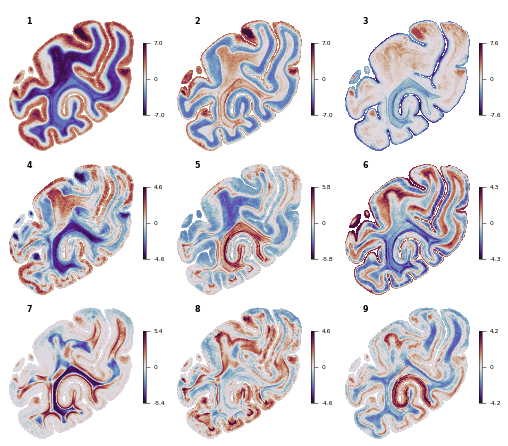

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# Create a figure with 2 rows and 4 columns of subplots
fig, axs = plt.subplots(3, 3, figsize=(7, 6))

# Iterate through the first 8 elements and plot them
for i in range(9):
    row = i // 3
    col = i % 3
    
    # Get the data for the current subplot
    current_data = pca_values[i].copy()
    
    # Clip the data to the 1% and 99% quantiles
    q_min = np.percentile(current_data, 0.2)
    q_max = np.percentile(current_data, 99.8)
    current_data = np.clip(current_data, q_min, q_max)

    # Mask pcas
    # current_data[~mask] = 0
    
    # Calculate center crop dimensions
    start_row = 80 # 80
    end_row = 420
    start_col = 30 # 75
    end_col = 415
    current_data = current_data[start_row:end_row, start_col:end_col]

    current_mask = mask.copy()[start_row:end_row, start_col:end_col]
    
    # Set the colormap to 'bwr' and center it around 0
    vmin = min(current_data.min(), -current_data.max())
    vmax = -vmin
    im = axs[row, col].imshow(current_data[::-1].T, cmap='twilight_shifted', vmin=vmin, vmax=vmax)

    axs[row, col].imshow(current_mask[::-1, :].T, cmap=cmap, interpolation='nearest')
    
    # Remove axis coordinates
    axs[row, col].axis('off')
    
    # Add a colorbar with 50% height of the subplot
    cbar = fig.colorbar(im, ax=axs[row, col], shrink=0.5)
    
    # Set the colorbar ticks with rounded digits
    cbar.set_ticks([vmin, 0, vmax])
    cbar.ax.set_yticklabels([f'{vmin:.1f}', '0', f'{vmax:.1f}'])

    # Adjust colorbar stroke size
    cbar.outline.set_linewidth(0.5)
    cbar.ax.tick_params(width=0.5)
    cbar.ax.tick_params(labelsize=6)
    
    # Add enumeration in the top left corner
    axs[row, col].text(0.15, 0.93, f'{i+1}', transform=axs[row, col].transAxes, fontsize=8, color='black',
                      fontweight='bold', va='top')

# Adjust the spacing between subplots
# plt.tight_layout()

plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, top=1, bottom=0)


# Save the plot with 400dpi
plt.savefig('doc/pca/main_components.pdf', dpi=400)
plt.savefig('doc/pca/main_components.svg', dpi=400)

# Show the plot
plt.show()


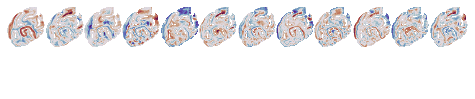

In [23]:
import matplotlib.pyplot as plt
import numpy as np

# Set global font size
plt.rcParams.update({'font.size': 4, 'axes.linewidth': 0.5, 'font.weight': 'bold'})

# Create a figure with 2 rows and 4 columns of subplots
fig, axs = plt.subplots(2, 12, figsize=(6.4, 1.2))

# Iterate through the first 8 elements and plot them
for i in range(24):
    row = i // 12
    col = i % 12
    
    if i+8 < len(pca_values):
            
        # Get the data for the current subplot
        current_data = pca_values[i+8].copy()
        
        # Clip the data to the 1% and 99% quantiles
        q_min = np.percentile(current_data, 0.2)
        q_max = np.percentile(current_data, 99.8)
        current_data = np.clip(current_data, q_min, q_max)

        current_mask = mask.copy()[start_row:end_row, start_col:end_col]
        
        # Calculate center crop dimensions
        start_row = 80
        end_row = 395
        start_col = 75
        end_col = 415
        current_data = current_data[start_row:end_row, start_col:end_col]
        
        # Set the colormap to 'bwr' and center it around 0
        vmin = min(current_data.min(), -current_data.max())
        vmax = -vmin
        im = axs[row, col].imshow(current_data[::-1].T, cmap='twilight_shifted', vmin=vmin, vmax=vmax)

        axs[row, col].imshow(current_mask[::-1, :].T, cmap=cmap, interpolation='nearest')
    
    # Remove axis coordinates
    axs[row, col].axis('off')

# Adjust the spacing between subplots
# plt.tight_layout()

plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, top=1, bottom=0)


# Save the plot with 400dpi
plt.savefig('doc/pca/secondary_components.pdf', dpi=400)
plt.savefig('doc/pca/secondary_components.svg', dpi=400)

# Show the plot
plt.show()
